In [22]:
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
import pandas as pd

In [23]:
def parse_ip_port(hex_ip, port):
    """Parses a hexadecimal IP and port to a human-readable string."""
    try:
        # ip = '.'.join(str(int(hex_ip[i:i+2], 16)) for i in range(0, 8, 2))
        # return f"{ip}:{port}"
        # return f"{ip}"
        
        ip_list=[str(int(hex_ip[i:i+2], 16)) for i in range(0, 8, 2)]
        return f"Host-{ip_list[2]}"
        
    except ValueError as e:
        print(f"Error parsing IP:Port - {hex_ip}:{port}")
        return "0.0.0.0:0"

dict_keys([('Host-1', 'Host-2'), ('Host-0', 'Host-2')])


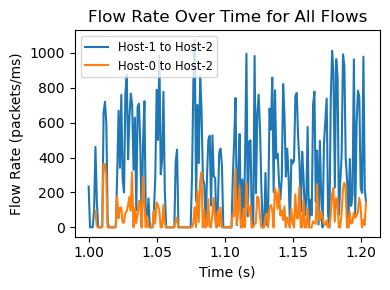

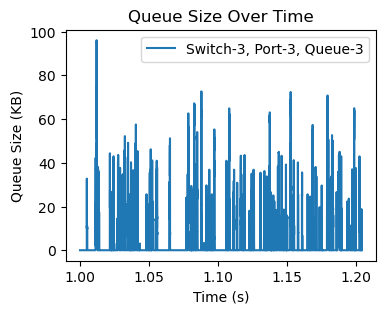

In [24]:

# Read and parse the log file
log_file_path = 'tr_1.log'  # Replace with your actual log file path

# Initialize data structures
flow_packets = defaultdict(list)  # Key: (src, dst), Value: list of timestamps (ns)
queue_sizes = defaultdict(list)  # Key: (node, port, queue), Value: list of (timestamp, queue size) tuples
with open(log_file_path, 'r') as file:
    for line in file:
        parts = line.split()
        
        event_type = parts[4]  # Assuming the event type is at this position
        pkt_type = parts[10]  # Assuming the packet type is at this position
        
        timestamp_ns = int(parts[0])
        
        if event_type == "Enqu" or event_type == "Dequ":
            node = parts[1].split(':')[1]
            port, queue = map(int, parts[2].split(':'))
            queue_size = float(parts[3])
            # Store queue size by node, port, and queue
            queue_sizes[(node, port, queue)].append((timestamp_ns, queue_size))
        
        
        if event_type == "Recv" and pkt_type=='U':  # Change "recv" to the actual keyword for receive events
            src = parse_ip_port(parts[6], parts[8])
            dst = parse_ip_port(parts[7], parts[9])
            # Store packet timestamp by flow
            flow_packets[(src, dst)].append(timestamp_ns)
        
# Calculate flow rate using a 1ms window
window_size_ns = 1e6  # 1ms in nanoseconds
flow_rates = defaultdict(list)  # Key: (src, dst), Value: list of (timestamp, rate) tuples

print(flow_packets.keys())
for flow_id, timestamps in flow_packets.items():
    start_time = min(timestamps)
    end_time = max(timestamps)
    time = start_time
    while time <= end_time:
        window_end = time + window_size_ns
        packets_in_window = len([t for t in timestamps if time <= t < window_end])
        flow_rate = packets_in_window / (window_size_ns / 1e6)  # packets per second
        flow_rates[flow_id].append((time, flow_rate))
        time += window_size_ns

# Plot flow rates over time for a selected flow (for simplicity, plot the first flow)
plt.figure(figsize=(4, 3))
# Iterate over each flow and plot its flow rate over time
for flow_id, rates in flow_rates.items():
    times, rates = zip(*rates)
    plt.plot(np.array(times) / 1e9, rates, label=f"{flow_id[0]} to {flow_id[1]}")

plt.xlabel('Time (s)')
plt.ylabel('Flow Rate (packets/ms)')
plt.title('Flow Rate Over Time for All Flows')
plt.legend(loc='upper left', fontsize='small')  # Adjust legend placement
plt.tight_layout()  # Adjust layout to make room for the legend
plt.show()

# Plot queue size over time for a specific queue (for simplicity, plot the first queue)
plt.figure(figsize=(4, 3))
selected_queue = list(queue_sizes.keys())[0]
timestamps, sizes = zip(*queue_sizes[selected_queue])
plt.plot(np.array(timestamps) / 1e9, np.array(sizes)/1024, label=f"Switch-{selected_queue[0]}, Port-{selected_queue[1]}, Queue-{selected_queue[2]}")
plt.xlabel('Time (s)')
plt.ylabel('Queue Size (KB)')
plt.title('Queue Size Over Time')
plt.legend()
plt.show()


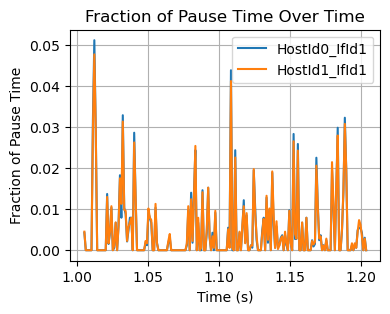

In [25]:
# Assuming the log file is named 'pfc_log.txt'
log_file_path = '/data2/lichenni/path_tc_test/shard0_nflows1000_nhosts3_lr10Gbps/pfc_topo-pl-3_s1.txt'

# Define column names
columns = ['Timestamp', 'Node ID', 'Node Type', 'Interface Index', 'PFC Event']

# Read the log file into a DataFrame
df = pd.read_csv(log_file_path, sep=' ', names=columns)

# Convert 'Timestamp' column to nanoseconds (assuming it's in ns)
df['Timestamp'] = pd.to_numeric(df['Timestamp'])

# Sort DataFrame by timestamp
df.sort_values(by='Timestamp', inplace=True)

# Set the time window size in nanoseconds (ns)
time_window_ns = 1e6  # 1 ms in nanoseconds

# Calculate the total duration of the log in nanoseconds
total_duration_ns = df['Timestamp'].iloc[-1] - df['Timestamp'].iloc[0]

# Create an empty DataFrame to store the fraction of pause time for each time window
result_df = pd.DataFrame()

# Iterate over each node and interface
for (node_id, interface_index), group in df.groupby(['Node ID', 'Interface Index']):
    # Calculate the fraction of pause time for each time window
    time_bins = np.arange(group['Timestamp'].iloc[0], group['Timestamp'].iloc[-1], time_window_ns)
    pause_time_counts, _ = np.histogram(group['Timestamp'], bins=time_bins)
    pause_time_fraction = pause_time_counts / len(group)  # Fraction of pause time within each time window
    
    # Get the midpoint of each time window for plotting
    time_midpoints = time_bins[:-1] + (time_bins[1] - time_bins[0]) / 2
    
    # Append the results to the DataFrame, aligning with the time windows
    result_df[f'HostId{node_id}_IfId{interface_index}'] = pause_time_fraction

# Plot the fraction of pause time over time for each node and interface
plt.figure(figsize=(4, 3))
for column in result_df.columns:
    plt.plot(time_midpoints/1e9, result_df[column], label=column)

plt.xlabel('Time (s)')
plt.ylabel('Fraction of Pause Time')
plt.title(f'Fraction of Pause Time Over Time')
plt.legend()
plt.grid(True)
plt.show()


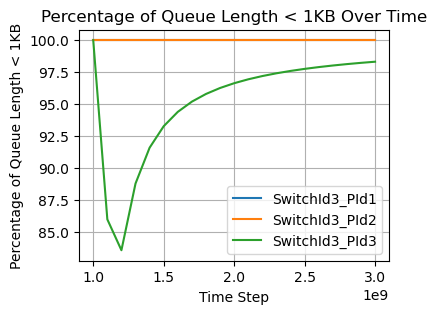

In [26]:
# Function to parse the log data
def parse_log(log_file):
    data = {"Time Step": [], "Queue ID": [], "Queue Lengths": []}
    with open(log_file, "r") as f:
        for line in f:
            if line.startswith("time:"):
                time_step = int(line.split(":")[1])
            else:
                parts = line.split()
                switch_id = int(parts[0])
                device_id = int(parts[1])
                queue_lengths = list(map(int, parts[2:]))
                data["Time Step"].append(time_step)
                data["Queue ID"].append(f"SwitchId{switch_id}_PId{device_id}")
                data["Queue Lengths"].append(queue_lengths)
    return pd.DataFrame(data)

# Function to calculate percentage of queue length < 1KB
def calculate_percentage(df):
    df["Percentage < 1KB"] = df["Queue Lengths"].apply(lambda x: sum(x[:1]) / sum(x) * 100)
    return df

# Function to plot the percentage over time for each node
def plot_percentage(df):
    plt.figure(figsize=(4, 3))
    for node_id in df["Queue ID"].unique():
        node_data = df[df["Queue ID"] == node_id]
        plt.plot(node_data["Time Step"], node_data["Percentage < 1KB"], label=f"{node_id}")
    plt.xlabel("Time Step")
    plt.ylabel("Percentage of Queue Length < 1KB")
    plt.title("Percentage of Queue Length < 1KB Over Time")
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
log_file = "/data2/lichenni/path_tc_test/shard0_nflows1000_nhosts3_lr10Gbps/qlen_topo-pl-3_s0.txt"
log_data = parse_log(log_file)
log_data_with_percentage = calculate_percentage(log_data)
plot_percentage(log_data_with_percentage)
